# import 使用到的套件

In [1]:
import numpy as np
from keras.layers import concatenate,Input, Dense, GaussianNoise,Lambda,Dropout,Activation,Conv1D,Reshape
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

from numpy.random import seed
from tensorflow import set_random_seed
from keras.utils import to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


# 宣告模擬的參數

In [2]:
M = 16
N = 7
ISI_TAPS=3
EQUALIZE_TAPS = 3
TRAINING_Esdb = 6

N_TRAIN=1000000
N_VAL=1000000
N_TEST=10000000

EPOCHS=30
BATCH=10000
PATIENCE=1000
SAVE= False
SAVE_PATH ='./lab4best.h5'

Esdb_TEST = np.arange(0,10,1)

# 宣告一般Function
## 1.cal_awgn_std(): 計算awgn_std
## 2.data_generator():取得資料
## 3.plot_result(): 畫出結果

In [3]:
def cal_awgn_std(EsN0db):
    N0  = 1 / np.power(10,EsN0db/10)
    awgn_std = np.sqrt(N0)
    return awgn_std

def data_generator(N_TRAIN=100000,N_VAL=1000000,N_TEST=10000000,M=16):
    
    x_train   = np.arange(N_TRAIN)%M
    x_val     = np.random.randint(M,size=N_VAL)
    x_test    = np.random.randint(M,size=N_TEST)
    
    x_train   = to_categorical(x_train,M)
    x_val     = to_categorical(x_val,M)
    x_test    = to_categorical(x_test,M)
    np.random.shuffle(x_train)
    return x_train,x_val,x_test


def plot_result(Esdb,l_BLER=0,l_BER=0):
    if(l_BLER):
        plt.plot(Esdb , l_BLER , 'bo-', linewidth=1, alpha=0.6,label='Block error rate')
        plt.title('Block Error Rate vs Es/N0 ')
        plt.yscale('log')
        plt.xlabel('Es/N0')
        plt.ylabel('Block error rate')
        plt.grid()
        plt.legend(loc='lower left',ncol = 1)
        plt.show()
    if(l_BER):
        plt.plot(Esdb , l_BER , 'bo-', linewidth=1, alpha=0.6,label='Bit error rate')
        plt.title('Bit Error Rate vs Es/N0 ')
        plt.yscale('log')
        plt.xlabel('Es/N0')
        plt.ylabel('Bit error rate')
        plt.grid()
        plt.legend(loc='lower left',ncol = 1)
        plt.show()

# 宣告Model及用在Model上的function
## 1.AWGN(): AWGN layer
## 2.code_normalization(): normalize Es to 1
## 3.get_model(): 取得AE model
## 4.train_model(): 訓練AE model

In [4]:
awgn_std = cal_awgn_std(TRAINING_Esdb)

def AWGN(x):
    noise = K.random_normal(shape=K.shape(x),mean=0.0,stddev=awgn_std)
    return x + noise

def code_normalization(x):
    return np.sqrt(K.int_shape(x)[1])*K.l2_normalize(x,axis=1)

def get_model(m=16,n=7,verbose=1):
    input_signal = Input(shape=(m,))
    encoded1     = Dense(m,activation='relu',name='encoded1')(input_signal)
    encoded2     = Dense(n,activation='linear',name='encoded2')(encoded1)
    encoder_out  = Lambda(code_normalization,name='encoder_out')(encoded2)

    AWGN_code1   = Lambda(AWGN,name='AWGN1') (encoder_out)

    decoded1     = Dense(m,activation='relu',name='decoded1') (AWGN_code1)
    decoded2     = Dense(m,activation='softmax',name='decoded2') (decoded1)

    autoencoder  = Model(input_signal, decoded2)
    encoder      = Model(input_signal, encoder_out) 
    
    decoder_input= Input(shape=(n,))
    deco         = autoencoder.layers[-2](decoder_input)
    deco         = autoencoder.layers[-1](deco)
    decoder      = Model(decoder_input, deco)

    autoencoder.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    if(verbose):
        autoencoder.summary()


    return autoencoder,encoder,decoder



def train_model(model,source,target,source_val,target_val,epochs=100, batch=1000,patience=1000,save=0,save_path ='./lab4best.h5'):
    if(SAVE):
        early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE)
        checkpointer = ModelCheckpoint(SAVE_PATH, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min', period=1)
        hist = model.fit(source,target,validation_data =(source_val,target_val),epochs=epochs,batch_size=batch,callbacks=[checkpointer,early_stopping],shuffle=True)
        return model,hist
    
    else:
        early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE)
        hist = model.fit(source,target,validation_data =(source_val,target_val),epochs=epochs,batch_size=batch,callbacks=[early_stopping],shuffle=True)
        return model,hist

# Main Function

In [5]:
x_train,x_val,x_test = data_generator(N_TRAIN,N_VAL,N_TEST,M)
autoencoder,encoder,decoder = get_model(M,N,verbose=1)
autoencoder,hist = train_model(autoencoder,x_train,x_train,x_val,x_val,EPOCHS,BATCH,PATIENCE,SAVE,SAVE_PATH)
autoencoder_weights = autoencoder.get_weights()

l_BLER = list()
l_BER  = list()
for SNR in Esdb_TEST :
    def AWGN(x):
        noise = K.random_normal(shape=K.shape(x),mean=0.0,stddev=cal_awgn_std(SNR))
        return x + noise
    autoencoder,encoder,decoder = get_model(M,N,verbose=0)
    autoencoder.set_weights(autoencoder_weights)
    preds = autoencoder.predict(x_test,batch_size=BATCH,verbose=1)
    BLER = np.sum(np.argmax(preds,axis=1) != np.argmax(x_test,axis=1)) / N_TEST
    BER  = np.sum(np.unpackbits(np.argmax(x_test,axis=1).astype(np.uint8)).reshape((-1,8)).astype(int)[:,4:] != np.unpackbits(np.argmax(preds,axis=1).astype(np.uint8)).reshape((-1,8)).astype(int)[:,4:]) / (N_TEST*int(np.log2(M)))
    print('Es/N0:'+str(SNR)+'   BLER:'+str(BLER) +'   BER:'+str(BER))
    l_BLER.append(BLER)
    l_BER.append(BER)
np.save('BLER',np.array(l_BLER))
np.save('BER',np.array(l_BER))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
encoded1 (Dense)             (None, 16)                272       
_________________________________________________________________
encoded2 (Dense)             (None, 7)                 119       
_________________________________________________________________
encoder_out (Lambda)         (None, 7)                 0         
_________________________________________________________________
AWGN1 (Lambda)               (None, 7)                 0         
_________________________________________________________________
decoded1 (Dense)             (None, 16)                128       
_________________________________________________________________
decoded2 (Dense)             (None, 16)                272       
Total para

c:\users\eason\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mathtext.py:854: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
c:\users\eason\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mathtext.py:855: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


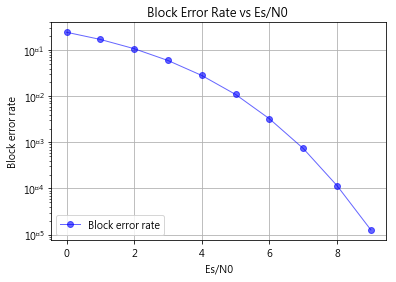

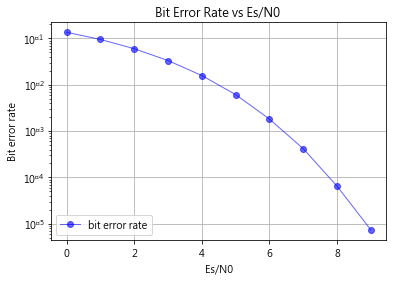

In [8]:
plot_result(Esdb_TEST,l_BLER,l_BER)